In [55]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import (
    Layer,
    Conv2D,
    Activation,
    MaxPooling2D,
    Input)
from keras.models import Model, Sequential
from keras.applications import vgg16, imagenet_utils
import keras.backend as K


class DActivation(Activation):
    def observation_field(self, field):
        return field


class ReverseBiasLayer(Layer):
    # basicall the same as Dense layer without activation
    def __init__(self, bias):
        super(ReverseBiasLayer, self).__init__()
        self.bias = K.constant((-1) * bias)

    def call(self, inputs, **kwargs):
        return inputs + self.bias

    def observation_field(self, field):
        return field


class Deconv():

    @staticmethod
    def get_observation2d(field, kernel_size, stride, padding_size, observe_size):
        """
        get observation field base on a given field, and some convLayer parameters

        :param field: Tuple[Tuple], (x,y of top_left block, x,y of bottom_right block): eg:  ((1,2),(4,5))
            it means a box from fmap[1, 2] to fmap[4, 5]
        :param: kernel_size: int
        :param: stride: int
        :param: padding_size: int
        :param: observe_size: int, the input square size of the convLayer. as maximum of observation loc
        """

        top_left, bottom_right = field

        affine_tl = lambda x: max(0, stride * x - padding_size)
        top_left_new = (affine_tl(top_left[0]), affine_tl(top_left[1]))

        affine_br = lambda x: min(observe_size, stride * x + kernel_size - 1 - padding_size)
        bottom_right_new = (affine_br(bottom_right[0]), affine_br(bottom_right[1]))

        return top_left_new, bottom_right_new


class DeConv2D(Conv2D, Deconv):

    def __init__(self, *args, **kwargs):
        super(DeConv2D, self).__init__(*args, **kwargs)

        if self.strides == (1, 1) and self.padding == "same":
            self.pad_size = self.kernel_size[0] // 2  # needed for calcualate observation_field
        else:
            self.pad_size = 0

    def observation_field(self, field):
        return super().get_observation2d(field,
                                         kernel_size=self.kernel_size[0],
                                         stride=self.strides[0],
                                         padding_size=1,
                                         observe_size=self.output_shape[1])  # None, fmap_size, fmap_size, n_channels


class MaxUnPooling2D(Layer, Deconv):
    # basicall the same as Dense layer without activation
    # assert pool_size == strides
    def __init__(self, switch_matrix, pool_size):
        super(MaxUnPooling2D, self).__init__()
        self.switch_matrix = K.constant(switch_matrix)
        self.pool_size = pool_size

    def call(self, inputs, **kwargs):
        return tf.repeat(tf.repeat(inputs, 2, axis=1), 2, axis=2) * self.switch_matrix

    def observation_field(self, field):
        return super().get_observation2d(field,
                                         kernel_size=self.pool_size[0],
                                         stride=self.pool_size[0],
                                         padding_size=0,
                                         observe_size=float("Inf"))
        # top_left, bottom_right = field
        # self.top_left = (top_left[0] * self.pool_size, top_left[1] * self.pool_size)
        # self.bottom_right = ((bottom_right[0] + 1) * self.pool_size - 1,
        #                     (bottom_right[1] + 1) * self.pool_size - 1)
        # return self.top_left, self.bottom_right


class DeConv2DModel(Sequential):

    @classmethod
    def from_conv2d(cls, model, n_layers, current_feature_maps, lyid_feature_maps):
        deconv_layers = cls()
        deconv_layers.add(Input(shape=model.layers[n_layers].output_shape[1:]))
        for i in range(n_layers, 0, -1):
            if isinstance(model.layers[i], Conv2D):
                deconv_layers.add(cls.get_activation())
                deconv_layers.add(cls.get_deconv2d_reverse_bias(model.layers[i]))
                deconv_layers.add(cls.get_deconv2d(model.layers[i]))
            if isinstance(model.layers[i], MaxPooling2D):
                deconv_layers.add(
                    cls.get_maxunpool2d(model.layers[i], current_feature_maps, lyid_feature_maps.index(i)))
        return deconv_layers

    def observation_field(self, loc):
        observation_field = (loc, loc)
        for i_layer, layer in enumerate(self.layers):
            observation_field = layer.observation_field(observation_field)
        return observation_field

    @staticmethod
    def get_deconv2d_reverse_bias(conv2d_layer: Conv2D):
        return ReverseBiasLayer(conv2d_layer.get_weights()[1])

    @staticmethod
    def get_activation():
        return DActivation("relu")

    @staticmethod
    def get_deconv2d(conv2d_layer: Conv2D):
        W = conv2d_layer.get_weights()[0]
        # W: kernel_width, kernel_height, kernel_depth, n_filters

        # Reverse the conv operation
        W = np.transpose(W, (0, 1, 3, 2))
        # Transpose the columns and rows
        W = W[::-1, ::-1, :, :]

        n_filters = W.shape[3]
        kernel_size = W.shape[0]
        strides = conv2d_layer.strides
        padding = conv2d_layer.padding
        b = np.zeros(n_filters)

        return DeConv2D(n_filters, kernel_size=kernel_size,
                        strides=strides,
                        padding=padding,
                        kernel_initializer=tf.constant_initializer(W),
                        bias_initializer=tf.constant_initializer(b),
                        trainable=False)

    @staticmethod
    def get_maxunpool2d(maxpool_layer: MaxPooling2D, current_feature_maps, id_layer):
        strides = maxpool_layer.strides
        pool_size = maxpool_layer.pool_size
        assert strides == pool_size  # otherwise it will be very hard to implement
        size = pool_size[0]

        current_fmap = current_feature_maps[id_layer][0]
        previous_fmap = current_feature_maps[id_layer - 1][0]
        assert current_fmap.shape[0] == previous_fmap.shape[0] // size

        switch_matrix = DeConv2DModel.switch_matrix_2d(current_fmap, previous_fmap, size)
        return MaxUnPooling2D(switch_matrix, maxpool_layer.pool_size)

    @staticmethod
    def switch_matrix_2d(fmap, vmap, size):
        # todo: could further optimize
        switch_matrix = []
        for k in range(fmap.shape[2]):
            switch_locs = []
            for i in range(fmap.shape[0]):
                for j in range(fmap.shape[1]):
                    # get index
                    max_pool_field = vmap[i * size: i * size + size, j * size: j * size + size, k]
                    switch_locs.append(DeConv2DModel.max_mask(max_pool_field))

            switch_locs = np.reshape(switch_locs, (fmap.shape[0], fmap.shape[1], size, size))
            rows = []
            for i in range(switch_locs.shape[0]):
                columns = [switch_locs[i, j, :, :] for j in range(switch_locs.shape[1])]
                rows.append(np.hstack(columns))
            switch_locs = np.vstack(rows)

            switch_matrix.append(switch_locs)

        # switch_matrix: channel, height, width
        switch_matrix = np.array(switch_matrix)
        switch_matrix = np.transpose(switch_matrix, (1, 2, 0))
        return switch_matrix

    @staticmethod
    def max_mask(x):
        mask = np.zeros(np.prod(x.shape))
        mask[np.argmax(x)] = 1
        mask = np.reshape(mask, x.shape)
        return mask

    @staticmethod
    def test(model, feature_maps):
        # test deconv layers
        d2d = DeConv2DModel.get_deconv2d(model.layers[1])
        rb = DeConv2DModel.get_deconv2d_reverse_bias(model.layers[1])

        test_model = Sequential()
        test_model.add(Input(shape=model.layers[1].output_shape[1:]))
        test_model.add(rb)
        test_model.add(d2d)
        test_model.summary()

        img_re = test_model.predict(feature_maps[0])[0]
        visualize_img(img_re)


def load_img(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224), resample=PIL.Image.NEAREST)
    img_array = np.array(img)
    img_array = img_array[np.newaxis, :]
    img_array = img_array.astype(np.float)
    img_array = imagenet_utils.preprocess_input(img_array)
    print(img_array.shape)
    return img_array


def visualize_img(img_data, examinate=False):
    if examinate:
        plt.imshow(img_data)
        plt.show()

    print(img_data.shape)
    img_data = img_data - img_data.min()
    img_data *= 1.0 / (img_data.max() + 1e-8)
    uint8_deconv = (img_data * 255).astype(np.uint8)
    # print(uint8_deconv)
    img = Image.fromarray(uint8_deconv, 'RGB')
    plt.imshow(img)
    plt.show()

    return img


def get_fmap_model(model, ixs_layers=(1, 3, 4, 6, 7, 9)):
    outputs = [model.layers[i].output for i in ixs_layers]
    fm_model = Model(inputs=model.inputs, outputs=outputs)
    model.trainable = False
    return fm_model


def get_deconv_model(model, n_layers, current_feature_maps, lyid_feature_maps):
    lyid_feature_maps = list(lyid_feature_maps)
    return DeConv2DModel.from_conv2d(model, n_layers, current_feature_maps, lyid_feature_maps)


def plot_feature_maps(feature_maps, square=4):
    for fmap in feature_maps:
        print(fmap.shape)
        # plot all 64 maps in an 8x8 squares
        ix = 0
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = plt.subplot(square, square, ix + 1)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix], cmap='gray')
                ix += 1
        # show the figure
        plt.show()


def filter_fmap(fmap, i_filter, return_loc=True):
    fmap_filter = fmap[0][:, :, i_filter]
    print(fmap_filter.shape)

    max_ = np.argmax(fmap_filter)
    fmap_filter_mask = np.zeros(fmap_filter.shape[0] * fmap_filter.shape[1])
    fmap_filter_mask[max_] = 1
    fmap_filter_mask = np.reshape(fmap_filter_mask, fmap_filter.shape)

    fmap_mask = np.zeros(fmap.shape)
    fmap_mask[0, :, :, i_filter] = fmap_filter_mask

    fmap_filtered = fmap * fmap_mask
    print(fmap_filtered.shape)

    if return_loc:
        max_loc = (max_ // fmap_filter.shape[1], max_ % fmap_filter.shape[-1])
        return fmap_filtered, max_loc
    else:
        return fmap_filtered


def show_reconstruct_pattern(deconv_model: DeConv2DModel, fmap, img, i_filter=None):
    # highest activati within all fmaps
    if i_filter is None:
        max_ = np.argmax(fmap[0])
        i_filter = max_ % fmap[0].shape[-1]

    fmap_filtered, max_loc = filter_fmap(fmap, i_filter)

    tl, br = deconv_model.observation_field(max_loc)
    re_act = deconv_model.predict(fmap_filtered)[0]
    re_act_focus = re_act[tl[0]:br[0], tl[1]:br[1], :]

    visualize_img(re_act)
    visualize_img(re_act_focus)
    visualize_img(img[tl[0]:br[0], tl[1]:br[1], :])



(1, 224, 224, 3)
(224, 224, 3)


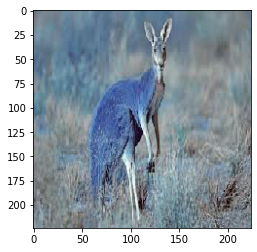

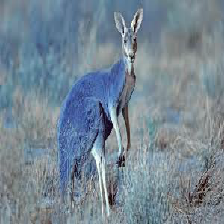

In [33]:
# Load example image and preprocess, and view
image_path = "./material/kangaroo.jpg"
img = load_img(image_path)
visualize_img(img[0])

In [34]:
# prepare the original model
model = vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
# prepare the feature map model
for i, layer in enumerate(model.layers):
    print("{}:\t{}".format(i, layer))
lyid_feature_maps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13,14,15]
fm_model = get_fmap_model(model, ixs_layers=lyid_feature_maps)
fm_model.summary()

# get fmaps
feature_maps = fm_model.predict(img)

# see feature_maps
# plot_feature_maps(feature_maps)


0:	<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f846c4975b0>
1:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c2b7040>
2:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c2e83a0>
3:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f846c301160>
4:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c301cd0>
5:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c2eab50>
6:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f846c30f370>
7:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c303910>
8:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c3199d0>
9:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c30f190>
10:	<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f846c322400>
11:	<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f846c3222e0>
12:	<tensorf

In [56]:
# get deconv model
i_layer = 14
deconv_model = get_deconv_model(model, n_layers=i_layer,
                                current_feature_maps=feature_maps,
                                lyid_feature_maps=lyid_feature_maps)
deconv_model.summary()

Model: "de_conv2d_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_un_pooling2d_12 (MaxUnPo (None, 28, 28, 512)       0         
_________________________________________________________________
d_activation (DActivation)   (None, 28, 28, 512)       0         
_________________________________________________________________
reverse_bias_layer_30 (Rever (None, 28, 28, 512)       0         
_________________________________________________________________
de_conv2d_30 (DeConv2D)      (None, 28, 28, 512)       2359808   
_________________________________________________________________
d_activation_1 (DActivation) (None, 28, 28, 512)       0         
_________________________________________________________________
reverse_bias_layer_31 (Rever (None, 28, 28, 512)       0         
_________________________________________________________________
de_conv2d_31 (DeConv2D)      (None, 28, 28, 512) 

In [57]:
# get fmap as input
i_fmap = lyid_feature_maps.index(i_layer)
fmap = feature_maps[i_fmap]
print(fmap.shape)


(1, 14, 14, 512)


(224, 224, 3)


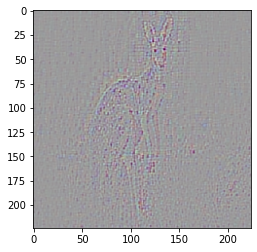

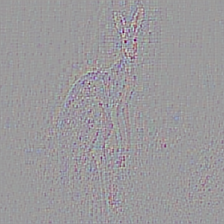

In [58]:
# test it
img_re = deconv_model.predict(fmap)[0]
visualize_img(img_re)


(14, 14)
(1, 14, 14, 512)
(224, 224, 3)


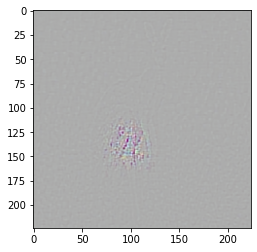

(99, 99, 3)


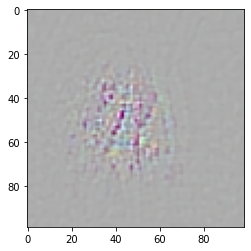

(99, 99, 3)


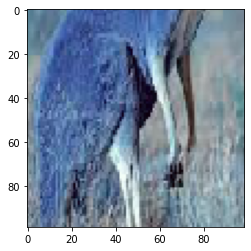

In [63]:
i_filter = 10
show_reconstruct_pattern(deconv_model, fmap, img[0], i_filter)

(14, 14)
(1, 14, 14, 512)
(224, 224, 3)


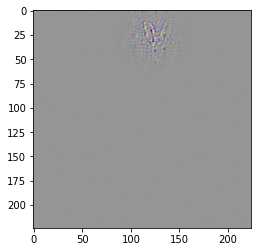

(73, 99, 3)


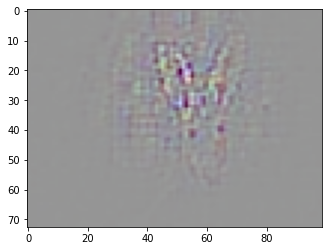

(73, 99, 3)


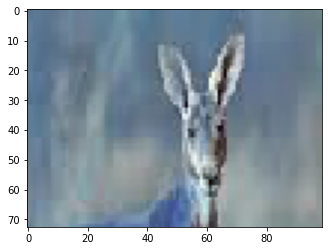

In [60]:
# most interesting i_filter
show_reconstruct_pattern(deconv_model, fmap, img[0])